In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
data.isnull().sum()

,0
ID,0
Split,0
Lesson_Topic,0
History,0
Expert_Human_Tutor,0
Peda_Strategies,0


No missing values after checking so the dataset is ready

### The distribution of Pedagogical Strategies

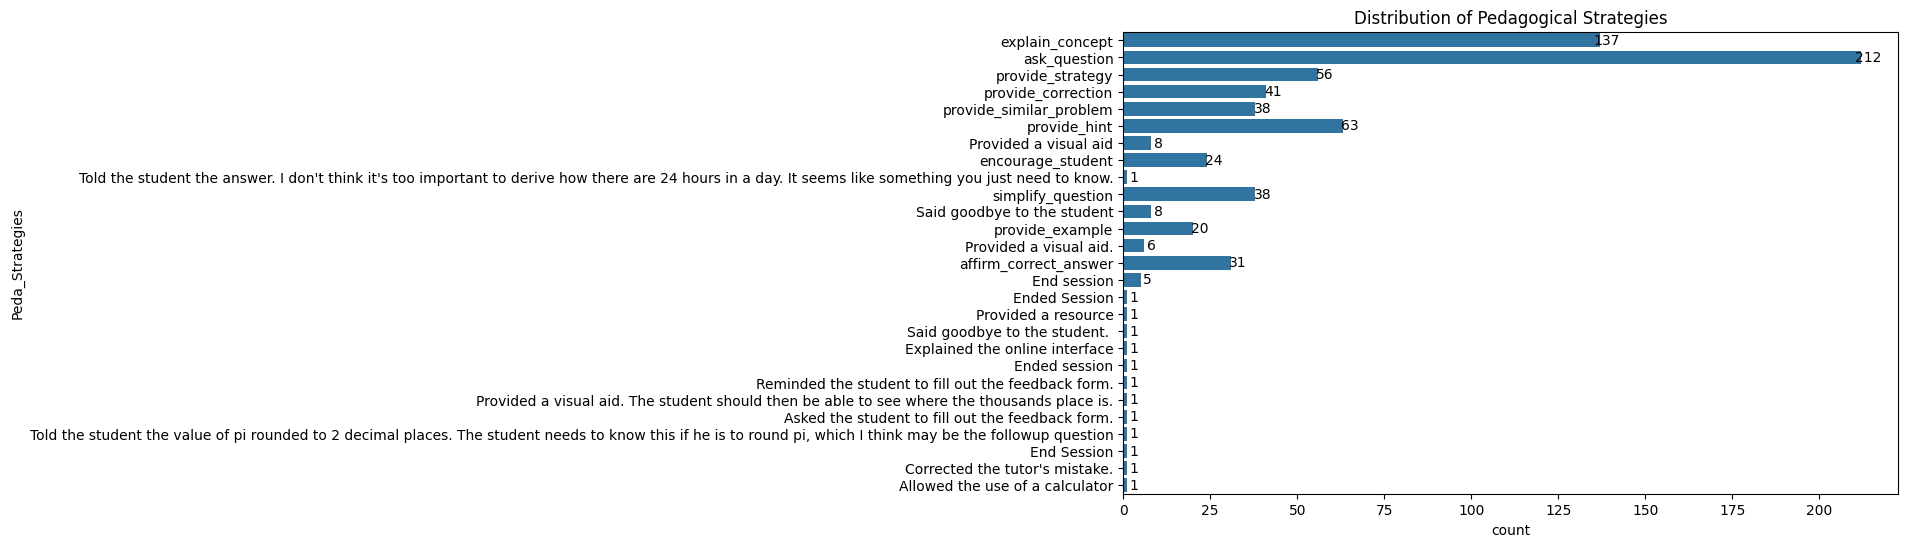

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='Peda_Strategies', data=data)
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(5, 0),
                textcoords='offset points')

plt.title('Distribution of Pedagogical Strategies')
plt.show()

## 1- Start with excluding some pedagogical stratigies

In [ ]:
file_path = '/content/bridge_data_task2_and_3.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)

,Expert_Human_Tutor,Peda_Strategies
0,"Hm, not quite",explain_concept
1,Correct! How would we write 0.8 in standard form?,ask_question
2,Great try! When we convert fractions to decima...,provide_strategy
3,Great try - looks like you solved the problem ...,provide_correction
4,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,"Sorry, I don't understand. Could you type it a...",explain_concept
6,"Ok, take your time",provide_hint
7,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,"Great try, but that is incorrect. We want to k...",ask_question
9,Great try! A rhombus has 4 congruent sides.,explain_concept


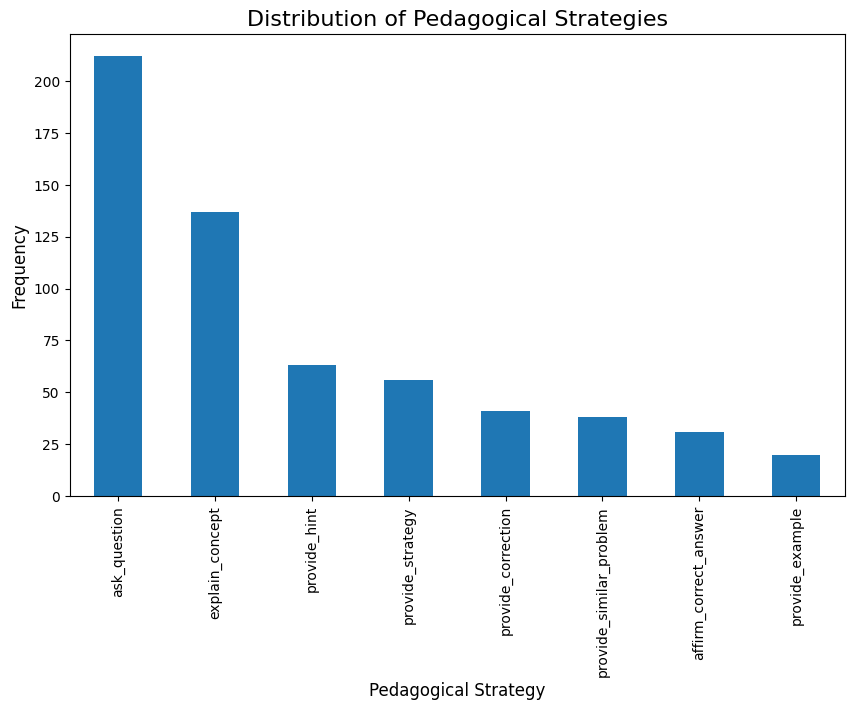

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
filtered_data['Peda_Strategies'].value_counts().plot(kind='bar')

plt.title('Distribution of Pedagogical Strategies', fontsize=16)
plt.xlabel('Pedagogical Strategy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()


## 2- Tokenizing the input (expert_human_tutor)

In [ ]:
!pip install transformers
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

filtered_data['tokenized_input'] = filtered_data['Expert_Human_Tutor'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True)
)

filtered_data[['Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-8-1d870ecc6fb7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['tokenized_input'] = filtered_data['Expert_Human_Tutor'].apply(


,Expert_Human_Tutor,tokenized_input
0,"Hm, not quite","[101, 20287, 1010, 2025, 3243, 102]"
1,Correct! How would we write 0.8 in standard form?,"[101, 6149, 999, 2129, 2052, 2057, 4339, 1014,..."
2,Great try! When we convert fractions to decima...,"[101, 2307, 3046, 999, 2043, 2057, 10463, 1288..."
3,Great try - looks like you solved the problem ...,"[101, 2307, 3046, 1011, 3504, 2066, 2017, 1333..."
4,Let's try another problem. Let's say Marty is ...,"[101, 2292, 1005, 1055, 3046, 2178, 3291, 1012..."
5,"Sorry, I don't understand. Could you type it a...","[101, 3374, 1010, 1045, 2123, 1005, 1056, 3305..."
6,"Ok, take your time","[101, 7929, 1010, 2202, 2115, 2051, 102]"
7,"Hmm, not quite. Could you let me know how you ...","[101, 17012, 1010, 2025, 3243, 1012, 2071, 201..."
8,"Great try, but that is incorrect. We want to k...","[101, 2307, 3046, 1010, 2021, 2008, 2003, 1654..."
9,Great try! A rhombus has 4 congruent sides.,"[101, 2307, 3046, 999, 1037, 1054, 23393, 8286..."


In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torch

max_length = 128

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]

    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]

    return torch.tensor(padded_inputs), torch.tensor(attention_masks)

padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([598, 128])
Attention Masks Shape: torch.Size([598, 128])


## 3- Dataset Splitting and Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

# 80% for training and 20% for validation
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")


Training Set: torch.Size([478, 128]), torch.Size([478, 128]), (478,)
Validation Set: torch.Size([120, 128]), torch.Size([120, 128]), (120,)


## 4- Fine-Tuning BERT

In [ ]:
!pip install transformers torch


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler


num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


optimizer = AdamW(model.parameters(), lr=2e-5)


epochs = 4
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')


    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")


    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4
Average Training Loss: 1.818630051612854
Validation Loss: 1.5869042426347733
Validation Accuracy: 48.33%
Epoch 2/4
Average Training Loss: 1.5289014021555583
Validation Loss: 1.5277975648641586
Validation Accuracy: 46.67%
Epoch 3/4
Average Training Loss: 1.2936828931172688
Validation Loss: 1.331947222352028
Validation Accuracy: 52.50%
Epoch 4/4
Average Training Loss: 1.1223633944988252
Validation Loss: 1.3137018084526062
Validation Accuracy: 55.00%


# --------------------------------------

# <3

# --------------------------------

## 1- I will try to use (Expert_human_tutor) as well as the (History) as my input.

In [ ]:
file_path = '/content/bridge_data_task2_and_3.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-23-636569595ba0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['combined_input'] = filtered_data['History'] + ' ' + filtered_data['Expert_Human_Tutor']
<ipython-input-23-636569595ba0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 128

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([598, 128])
Attention Masks Shape: torch.Size([598, 128])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")


Training Set: torch.Size([478, 128]), torch.Size([478, 128]), (478,)
Validation Set: torch.Size([120, 128]), torch.Size([120, 128]), (120,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 4
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")



    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4
Average Training Loss: 1.8482756614685059
Validation Loss: 1.6140347868204117
Validation Accuracy: 49.17%
Epoch 2/4
Average Training Loss: 1.6343379974365235
Validation Loss: 1.4872837662696838
Validation Accuracy: 48.33%
Epoch 3/4
Average Training Loss: 1.493030595779419
Validation Loss: 1.5426256507635117
Validation Accuracy: 45.83%
Epoch 4/4
Average Training Loss: 1.3443467915058136
Validation Loss: 1.4238727688789368
Validation Accuracy: 50.83%


When I combined both History and Expert_Human_Tutor, some of the most important parts of the text might be getting truncated.
So, I will increase max_length from 128 to 256

## 2- I will Increase the token length to ensure that it captures more context

In [ ]:
file_path = '/content/bridge_data_task2_and_3.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-29-42dfdbbac75d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['combined_input'] = filtered_data['History'] + ' ' + filtered_data['Expert_Human_Tutor']
<ipython-input-29-42dfdbbac75d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([598, 256])
Attention Masks Shape: torch.Size([598, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")


Training Set: torch.Size([478, 256]), torch.Size([478, 256]), (478,)
Validation Set: torch.Size([120, 256]), torch.Size([120, 256]), (120,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 4
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")



    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4
Average Training Loss: 1.784649956226349
Validation Loss: 1.5914432406425476
Validation Accuracy: 45.83%
Epoch 2/4
Average Training Loss: 1.6295164346694946
Validation Loss: 1.4687211215496063
Validation Accuracy: 54.17%
Epoch 3/4
Average Training Loss: 1.511117366949717
Validation Loss: 1.40422223508358
Validation Accuracy: 54.17%
Epoch 4/4
Average Training Loss: 1.2912974139054616
Validation Loss: 1.3695972859859467
Validation Accuracy: 53.33%


## 3- I will try to add (SEP) to mark seperation between different segments of the text + 20 epchos

In [ ]:
file_path = '/content/bridge_data_task2_and_3.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


Here, I added SEP 😀

In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-11-9d552980a339>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
<ipython-input-11-9d552980a339>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([598, 256])
Attention Masks Shape: torch.Size([598, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")


Training Set: torch.Size([478, 256]), torch.Size([478, 256]), (478,)
Validation Set: torch.Size([120, 256]), torch.Size([120, 256]), (120,)


Increased from 4 to 20 epchos

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")



    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.8748564879099527
Validation Loss: 1.7070196866989136
Validation Accuracy: 39.17%
Epoch 2/20
Average Training Loss: 1.72020343542099
Validation Loss: 1.5378927141427994
Validation Accuracy: 50.00%
Epoch 3/20
Average Training Loss: 1.5126035412152607
Validation Loss: 1.4248692095279694
Validation Accuracy: 52.50%
Epoch 4/20
Average Training Loss: 1.2724780400594076
Validation Loss: 1.2853707671165466
Validation Accuracy: 56.67%
Epoch 5/20
Average Training Loss: 0.9921188632647197
Validation Loss: 1.3356984704732895
Validation Accuracy: 59.17%
Epoch 6/20
Average Training Loss: 0.7984371105829875
Validation Loss: 1.2931159883737564
Validation Accuracy: 61.67%
Epoch 7/20
Average Training Loss: 0.6167061199744542
Validation Loss: 1.362368404865265
Validation Accuracy: 59.17%
Epoch 8/20
Average Training Loss: 0.442795892059803
Validation Loss: 1.3955062478780746
Validation Accuracy: 61.67%
Epoch 9/20
Average Training Loss: 0.31776554584503175
Validation Los

Overfitting: After epoch 6, the training loss continues to decrease, but the validation loss increases, and validation accuracy starts fluctuating. The model is overfitting.

Validation Loss Increase: Validation loss increases while validation accuracy slightly decreases or stays stable suggests the model is struggling to generalize.


# ==================================

# <3

# ===================================

## 1- Data agumentation, I tried to balance the imbalance distribution in the data

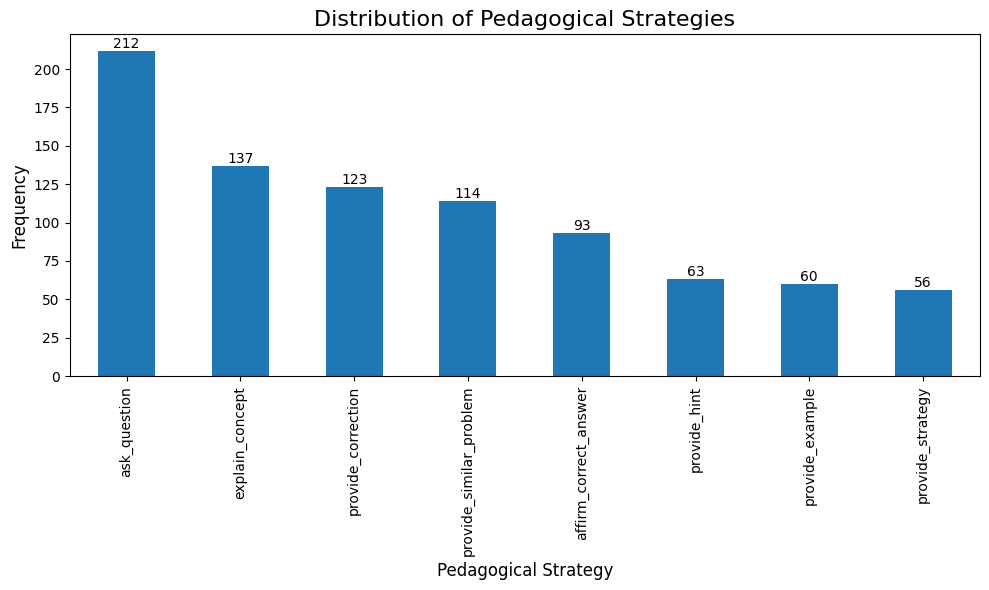

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = '/content/balanced_dataset.csv'

filtered_data = pd.read_csv(data_path)

plt.figure(figsize=(10, 6))
bars = filtered_data['Peda_Strategies'].value_counts().plot(kind='bar')

plt.title('Distribution of Pedagogical Strategies', fontsize=16)
plt.xlabel('Pedagogical Strategy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()


I tried to add pedagogical stratigies to the last 4 which are the least by paraphrasing

In [ ]:
file_path = '/content/balanced_dataset.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([858, 256])
Attention Masks Shape: torch.Size([858, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")


Training Set: torch.Size([686, 256]), torch.Size([686, 256]), (686,)
Validation Set: torch.Size([172, 256]), torch.Size([172, 256]), (172,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")



    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.97100653204807
Validation Loss: 1.8644923730330034
Validation Accuracy: 33.14%
Epoch 2/20
Average Training Loss: 1.7419272356255109
Validation Loss: 1.6678980697285046
Validation Accuracy: 44.77%
Epoch 3/20
Average Training Loss: 1.5042097513065782
Validation Loss: 1.3639104691418735
Validation Accuracy: 55.23%
Epoch 4/20
Average Training Loss: 1.2331862311030544
Validation Loss: 1.207071228460832
Validation Accuracy: 60.47%
Epoch 5/20
Average Training Loss: 0.9405029845792193
Validation Loss: 1.047139119018208
Validation Accuracy: 65.12%
Epoch 6/20
Average Training Loss: 0.6611095646093058
Validation Loss: 0.9231203442270105
Validation Accuracy: 69.77%
Epoch 7/20
Average Training Loss: 0.5201079783051513
Validation Loss: 0.8856215612454847
Validation Accuracy: 72.67%
Epoch 8/20
Average Training Loss: 0.3554708968068278
Validation Loss: 0.7992618273605
Validation Accuracy: 75.00%
Epoch 9/20
Average Training Loss: 0.25398072201845256
Validation Loss: 

as shown, the data augmentation played a big role in increasing the score, by like 20%

## 2- Added early stopping to keep track the validation loss
Track Validation Loss: After each epoch, the validation loss is computed.

early_stopping_patience | I set it to 3 epochs to wait without improvement before stopping.

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')


    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")


    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.8922465207964876
Validation Loss: 1.819603898308494
Validation Accuracy: 34.30%
Epoch 2/20
Average Training Loss: 1.7491308173467948
Validation Loss: 1.683619119904258
Validation Accuracy: 38.95%
Epoch 3/20
Average Training Loss: 1.5257884361023126
Validation Loss: 1.5481586998159236
Validation Accuracy: 51.16%
Epoch 4/20
Average Training Loss: 1.2756550159565239
Validation Loss: 1.287559758533131
Validation Accuracy: 59.88%
Epoch 5/20
Average Training Loss: 0.9785951071007307
Validation Loss: 1.1558315428820523
Validation Accuracy: 61.05%
Epoch 6/20
Average Training Loss: 0.7960640247478041
Validation Loss: 1.0211652246388523
Validation Accuracy: 66.28%
Epoch 7/20
Average Training Loss: 0.6200970244962115
Validation Loss: 0.8942206610332836
Validation Accuracy: 72.09%
Epoch 8/20
Average Training Loss: 0.4543497794589331
Validation Loss: 0.8322014348073439
Validation Accuracy: 76.74%
Epoch 9/20
Average Training Loss: 0.3459199348161387
Validation Los

The validation accuracy increased consistently over the first 10 epochs, peaking at **80.81%** at epoch 10, and remained relatively stable until early stopping.

Early stopping was correctly triggered after epoch 14 when the validation loss stopped improving, helping prevent overfitting.

# ====================================================

# <3

# ==========================

## 1- Adding Micro F1 score calculation + Calculating the accuracy of each class.

In [ ]:
file_path = '/content/balanced_dataset.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([858, 256])
Attention Masks Shape: torch.Size([858, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")


Training Set: torch.Size([686, 256]), torch.Size([686, 256]), (686,)
Validation Set: torch.Size([172, 256]), torch.Size([172, 256]), (172,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.9407344224841097
Validation Loss: 1.8324353261427446
Validation Accuracy: 40.12%
Micro F1 Score: 0.4012
Accuracy for class affirm_correct_answer: 65.22%
Accuracy for class ask_question: 92.50%
Accuracy for class explain_concept: 57.14%
Accuracy for class provide_correction: 4.17%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.7636307394781778
Validation Loss: 1.6382537971843372
Validation Accuracy: 47.67%
Micro F1 Score: 0.4767
Accuracy for class affirm_correct_answer: 73.91%
Accuracy for class ask_question: 85.00%
Accuracy for class explain_concept: 42.86%
Accuracy for class provide_correction: 37.50%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 38.46%
Accuracy for class provide_strategy: 0.00%
Epoch 3/20
Avera

High Accuracy: Classes like **affirm_correct_answer**, **ask_question**, **provide_correction**, and **provide_similar_problem** show consistently high accuracy, reaching above 90% in many cases.

Challenging Classes: Classes such as **provide_example** and **provide_hint**, which initially showed very low accuracy

Three of the high classes were actually been balanced using the Pre-trained T5 model, this verifies the T5 pre-trained model capability and relability.

## 2- Increase the text_length from 256 to 512 + Increase the batch_size from 16 to 32.

In [ ]:
file_path = '/content/balanced_dataset.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 512

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([858, 512])
Attention Masks Shape: torch.Size([858, 512])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")


Training Set: torch.Size([686, 512]), torch.Size([686, 512]), (686,)
Validation Set: torch.Size([172, 512]), torch.Size([172, 512]), (172,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.9601349288767034
Validation Loss: 1.8806755940119426
Validation Accuracy: 28.49%
Micro F1 Score: 0.2849
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 100.00%
Accuracy for class explain_concept: 3.57%
Accuracy for class provide_correction: 12.50%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 19.23%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.805815268646587
Validation Loss: 1.7433541417121887
Validation Accuracy: 40.12%
Micro F1 Score: 0.4012
Accuracy for class affirm_correct_answer: 21.74%
Accuracy for class ask_question: 97.50%
Accuracy for class explain_concept: 35.71%
Accuracy for class provide_correction: 37.50%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 23.08%
Accuracy for class provide_strategy: 0.00%
Epoch 3/20
Avera

it looks like Increasing the input length from 256 to 512 can lead to model degradation (too much noise)

A larger batch size (32) allows for faster training but requires more GPU memory. If the model struggles to fit longer sequences in memory, it may not learn as effectively



## 3- Decrease the token length to 256 again and the batch_size to 16 + Adjusting the learning rate (1-e5)

In [ ]:
file_path = '/content/balanced_dataset.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([858, 256])
Attention Masks Shape: torch.Size([858, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")

Training Set: torch.Size([686, 256]), torch.Size([686, 256]), (686,)
Validation Set: torch.Size([172, 256]), torch.Size([172, 256]), (172,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=1e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 2.0233016263606936
Validation Loss: 1.9316383816979148
Validation Accuracy: 23.26%
Micro F1 Score: 0.2326
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 100.00%
Accuracy for class explain_concept: 0.00%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.8593981875929722
Validation Loss: 1.8069556518034502
Validation Accuracy: 29.07%
Micro F1 Score: 0.2907
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 100.00%
Accuracy for class explain_concept: 0.00%
Accuracy for class provide_correction: 29.17%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 11.54%
Accuracy for class provide_strategy: 0.00%
Epoch 3/20
Average

it looks like that the previous learning rate I was using was better.

## 4- Revert back the original learning rate + increase batch size to 32

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 2.0009333166209133
Validation Loss: 1.9132143060366313
Validation Accuracy: 29.65%
Micro F1 Score: 0.2965
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 85.00%
Accuracy for class explain_concept: 35.71%
Accuracy for class provide_correction: 4.17%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 23.08%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.8056920821016484
Validation Loss: 1.7729874054590862
Validation Accuracy: 36.05%
Micro F1 Score: 0.3605
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 87.50%
Accuracy for class explain_concept: 42.86%
Accuracy for class provide_correction: 33.33%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 26.92%
Accuracy for class provide_strategy: 0.00%
Epoch 3/20
Averag

it's very clear the batch size made it worse.

## 5- Lastly, I will go back to the result where I got 80% but I will try to increase only the token size to 384 since it's the maximum recommended for BERT

In [ ]:
file_path = '/content/balanced_dataset.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=384, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 384

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([858, 384])
Attention Masks Shape: torch.Size([858, 384])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")


Training Set: torch.Size([686, 384]), torch.Size([686, 384]), (686,)
Validation Set: torch.Size([172, 384]), torch.Size([172, 384]), (172,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.9327909696933836
Validation Loss: 1.7383575222708962
Validation Accuracy: 37.79%
Micro F1 Score: 0.3779
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 95.00%
Accuracy for class explain_concept: 28.57%
Accuracy for class provide_correction: 33.33%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 42.31%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.5853314233380695
Validation Loss: 1.3719814582304521
Validation Accuracy: 56.98%
Micro F1 Score: 0.5698
Accuracy for class affirm_correct_answer: 65.22%
Accuracy for class ask_question: 85.00%
Accuracy for class explain_concept: 53.57%
Accuracy for class provide_correction: 62.50%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 73.08%
Accuracy for class provide_strategy: 0.00%
Epoch 3/20
Aver

This shows that the previous 256 input_length was the best.

# <3

-----------------------------------------
------------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------

# 1- Add Test set

In [ ]:
file_path = '/content/balanced_dataset.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([858, 256])
Attention Masks Shape: torch.Size([858, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

# First, split off 20% for the test set, then split the remaining 80% into train and validation sets (70% train, 30% validation)
train_inputs, temp_inputs, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)
val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_inputs, temp_masks, temp_labels, test_size=0.5, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([686, 256]), torch.Size([686, 256]), (686,)
Validation Set: torch.Size([86, 256]), torch.Size([86, 256]), (86,)
Test Set: torch.Size([86, 256]), torch.Size([86, 256]), (86,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.987644117931987
Validation Loss: 1.8857042988141377
Validation Accuracy: 23.26%
Micro F1 Score: 0.2326
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 100.00%
Accuracy for class explain_concept: 0.00%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.7652165030324183
Validation Loss: 1.6046562194824219
Validation Accuracy: 46.51%
Micro F1 Score: 0.4651
Accuracy for class affirm_correct_answer: 61.54%
Accuracy for class ask_question: 65.00%
Accuracy for class explain_concept: 64.29%
Accuracy for class provide_correction: 60.00%
Accuracy for class provide_example: 12.50%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 23.08%
Accuracy for class provide_strategy: 0.00%
Epoch 3/20
Averag

### As shown the score on the test set is around 77%

# 2- Test on GPT-4o Augmented Dataset

In [ ]:
file_path = '/content/balanced_dataset.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: When we look at the number of sid...,Good try! Let's try to count the number of sid...,provide_strategy
1,||| teacher: Here comes the next question. |||...,Can you show on the whiteboard your first step...,ask_question
2,||| teacher: Give it your best shot! ||| stude...,You're very close. This question is asking wha...,provide_correction
3,||| teacher: What’s the remainder when you div...,Right on! The remainder is 1.,affirm_correct_answer
4,"||| teacher: If you divide 25 by 5, what do yo...",Exactly! 5 is the right answer.,affirm_correct_answer
5,||| teacher: Please let me know once you compl...,"Ah, not quite. I like how we started by gettin...",explain_concept
6,||| teacher: Can you solve 3x = 12? ||| studen...,Try isolating x by dividing both sides by 3. T...,provide_strategy
7,||| teacher: The area in maths is the amount o...,Great! You can use either side as the length o...,affirm_correct_answer
8,||| teacher: Can you solve 40 divided by 8? ||...,Try thinking of it as ‘how many groups of 8 ar...,provide_strategy
9,||| student: sorry for the j that I tipe ||| t...,"Oh, what makes you say that?",explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: When we look at the number of sid...,Good try! Let's try to count the number of sid...,"[101, 1064, 1064, 1064, 3836, 1024, 2043, 2057..."
1,||| teacher: Here comes the next question. |||...,Can you show on the whiteboard your first step...,"[101, 1064, 1064, 1064, 3836, 1024, 2182, 3310..."
2,||| teacher: Give it your best shot! ||| stude...,You're very close. This question is asking wha...,"[101, 1064, 1064, 1064, 3836, 1024, 2507, 2009..."
3,||| teacher: What’s the remainder when you div...,Right on! The remainder is 1.,"[101, 1064, 1064, 1064, 3836, 1024, 2054, 1521..."
4,"||| teacher: If you divide 25 by 5, what do yo...",Exactly! 5 is the right answer.,"[101, 1064, 1064, 1064, 3836, 1024, 2065, 2017..."
5,||| teacher: Please let me know once you compl...,"Ah, not quite. I like how we started by gettin...","[101, 1064, 1064, 1064, 3836, 1024, 3531, 2292..."
6,||| teacher: Can you solve 3x = 12? ||| studen...,Try isolating x by dividing both sides by 3. T...,"[101, 1064, 1064, 1064, 3836, 1024, 2064, 2017..."
7,||| teacher: The area in maths is the amount o...,Great! You can use either side as the length o...,"[101, 1064, 1064, 1064, 3836, 1024, 1996, 2181..."
8,||| teacher: Can you solve 40 divided by 8? ||...,Try thinking of it as ‘how many groups of 8 ar...,"[101, 1064, 1064, 1064, 3836, 1024, 2064, 2017..."
9,||| student: sorry for the j that I tipe ||| t...,"Oh, what makes you say that?","[101, 1064, 1064, 1064, 3076, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([1088, 256])
Attention Masks Shape: torch.Size([1088, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

# First, split off 20% for the test set, then split the remaining 80% into train and validation sets (70% train, 30% validation)
train_inputs, temp_inputs, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)
val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_inputs, temp_masks, temp_labels, test_size=0.5, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([870, 256]), torch.Size([870, 256]), (870,)
Validation Set: torch.Size([109, 256]), torch.Size([109, 256]), (109,)
Test Set: torch.Size([109, 256]), torch.Size([109, 256]), (109,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.8837335218082776
Validation Loss: 1.6301049504961287
Validation Accuracy: 48.62%
Micro F1 Score: 0.4862
Accuracy for class affirm_correct_answer: 66.67%
Accuracy for class ask_question: 66.67%
Accuracy for class explain_concept: 53.33%
Accuracy for class provide_correction: 37.50%
Accuracy for class provide_example: 25.00%
Accuracy for class provide_hint: 70.00%
Accuracy for class provide_similar_problem: 75.00%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.3984826987439936
Validation Loss: 1.2535932574953352
Validation Accuracy: 60.55%
Micro F1 Score: 0.6055
Accuracy for class affirm_correct_answer: 93.33%
Accuracy for class ask_question: 93.33%
Accuracy for class explain_concept: 46.67%
Accuracy for class provide_correction: 37.50%
Accuracy for class provide_example: 87.50%
Accuracy for class provide_hint: 50.00%
Accuracy for class provide_similar_problem: 75.00%
Accuracy for class provide_strategy: 25.00%
Epoch 3/2

### The test score of the augmented set using GPT-4o is around 75%

# 3- Try expert_human_tutor as an input Only

In [ ]:
file_path = '/content/balanced_dataset.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,Expert_Human_Tutor,Peda_Strategies
0,Good try! Let's try to count the number of sid...,provide_strategy
1,Can you show on the whiteboard your first step...,ask_question
2,You're very close. This question is asking wha...,provide_correction
3,Right on! The remainder is 1.,affirm_correct_answer
4,Exactly! 5 is the right answer.,affirm_correct_answer
5,"Ah, not quite. I like how we started by gettin...",explain_concept
6,Try isolating x by dividing both sides by 3. T...,provide_strategy
7,Great! You can use either side as the length o...,affirm_correct_answer
8,Try thinking of it as ‘how many groups of 8 ar...,provide_strategy
9,"Oh, what makes you say that?",explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,Expert_Human_Tutor,tokenized_input
0,Good try! Let's try to count the number of sid...,"[101, 2204, 3046, 999, 2292, 1005, 1055, 3046,..."
1,Can you show on the whiteboard your first step...,"[101, 2064, 2017, 2265, 2006, 1996, 2317, 6277..."
2,You're very close. This question is asking wha...,"[101, 2017, 1005, 2128, 2200, 2485, 1012, 2023..."
3,Right on! The remainder is 1.,"[101, 2157, 2006, 999, 1996, 6893, 2003, 1015,..."
4,Exactly! 5 is the right answer.,"[101, 3599, 999, 1019, 2003, 1996, 2157, 3437,..."
5,"Ah, not quite. I like how we started by gettin...","[101, 6289, 1010, 2025, 3243, 1012, 1045, 2066..."
6,Try isolating x by dividing both sides by 3. T...,"[101, 3046, 11163, 22248, 1060, 2011, 16023, 2..."
7,Great! You can use either side as the length o...,"[101, 2307, 999, 2017, 2064, 2224, 2593, 2217,..."
8,Try thinking of it as ‘how many groups of 8 ar...,"[101, 3046, 3241, 1997, 2009, 2004, 1520, 2129..."
9,"Oh, what makes you say that?","[101, 2821, 1010, 2054, 3084, 2017, 2360, 2008..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([1088, 256])
Attention Masks Shape: torch.Size([1088, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

# First, split off 20% for the test set, then split the remaining 80% into train and validation sets (70% train, 30% validation)
train_inputs, temp_inputs, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)
val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_inputs, temp_masks, temp_labels, test_size=0.5, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([870, 256]), torch.Size([870, 256]), (870,)
Validation Set: torch.Size([109, 256]), torch.Size([109, 256]), (109,)
Test Set: torch.Size([109, 256]), torch.Size([109, 256]), (109,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.8292857711965387
Validation Loss: 1.4209308283669608
Validation Accuracy: 53.21%
Micro F1 Score: 0.5321
Accuracy for class affirm_correct_answer: 86.67%
Accuracy for class ask_question: 73.33%
Accuracy for class explain_concept: 66.67%
Accuracy for class provide_correction: 37.50%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 20.00%
Accuracy for class provide_similar_problem: 75.00%
Accuracy for class provide_strategy: 55.00%
Epoch 2/20
Average Training Loss: 1.1998177289962768
Validation Loss: 1.1186574016298567
Validation Accuracy: 62.39%
Micro F1 Score: 0.6239
Accuracy for class affirm_correct_answer: 100.00%
Accuracy for class ask_question: 86.67%
Accuracy for class explain_concept: 66.67%
Accuracy for class provide_correction: 37.50%
Accuracy for class provide_example: 50.00%
Accuracy for class provide_hint: 50.00%
Accuracy for class provide_similar_problem: 75.00%
Accuracy for class provide_strategy: 35.00%
Epoch 3/

### Overfitting, Test score on expert input only gives 74%

# 4- Try reducing the token length from 256 to 128

In [ ]:
file_path = '/content/balanced_dataset.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,Expert_Human_Tutor,Peda_Strategies
0,Good try! Let's try to count the number of sid...,provide_strategy
1,Can you show on the whiteboard your first step...,ask_question
2,You're very close. This question is asking wha...,provide_correction
3,Right on! The remainder is 1.,affirm_correct_answer
4,Exactly! 5 is the right answer.,affirm_correct_answer
5,"Ah, not quite. I like how we started by gettin...",explain_concept
6,Try isolating x by dividing both sides by 3. T...,provide_strategy
7,Great! You can use either side as the length o...,affirm_correct_answer
8,Try thinking of it as ‘how many groups of 8 ar...,provide_strategy
9,"Oh, what makes you say that?",explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True)
)

filtered_data[['Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,Expert_Human_Tutor,tokenized_input
0,Good try! Let's try to count the number of sid...,"[101, 2204, 3046, 999, 2292, 1005, 1055, 3046,..."
1,Can you show on the whiteboard your first step...,"[101, 2064, 2017, 2265, 2006, 1996, 2317, 6277..."
2,You're very close. This question is asking wha...,"[101, 2017, 1005, 2128, 2200, 2485, 1012, 2023..."
3,Right on! The remainder is 1.,"[101, 2157, 2006, 999, 1996, 6893, 2003, 1015,..."
4,Exactly! 5 is the right answer.,"[101, 3599, 999, 1019, 2003, 1996, 2157, 3437,..."
5,"Ah, not quite. I like how we started by gettin...","[101, 6289, 1010, 2025, 3243, 1012, 1045, 2066..."
6,Try isolating x by dividing both sides by 3. T...,"[101, 3046, 11163, 22248, 1060, 2011, 16023, 2..."
7,Great! You can use either side as the length o...,"[101, 2307, 999, 2017, 2064, 2224, 2593, 2217,..."
8,Try thinking of it as ‘how many groups of 8 ar...,"[101, 3046, 3241, 1997, 2009, 2004, 1520, 2129..."
9,"Oh, what makes you say that?","[101, 2821, 1010, 2054, 3084, 2017, 2360, 2008..."


In [ ]:
import torch

max_length = 128

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([1088, 128])
Attention Masks Shape: torch.Size([1088, 128])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

# First, split off 20% for the test set, then split the remaining 80% into train and validation sets (70% train, 30% validation)
train_inputs, temp_inputs, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)
val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_inputs, temp_masks, temp_labels, test_size=0.5, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([870, 128]), torch.Size([870, 128]), (870,)
Validation Set: torch.Size([109, 128]), torch.Size([109, 128]), (109,)
Test Set: torch.Size([109, 128]), torch.Size([109, 128]), (109,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.8505260705947877
Validation Loss: 1.5329280069896154
Validation Accuracy: 51.38%
Micro F1 Score: 0.5138
Accuracy for class affirm_correct_answer: 86.67%
Accuracy for class ask_question: 86.67%
Accuracy for class explain_concept: 46.67%
Accuracy for class provide_correction: 50.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 60.00%
Accuracy for class provide_similar_problem: 75.00%
Accuracy for class provide_strategy: 5.00%
Epoch 2/20
Average Training Loss: 1.35502624836835
Validation Loss: 1.2183805363518851
Validation Accuracy: 53.21%
Micro F1 Score: 0.5321
Accuracy for class affirm_correct_answer: 93.33%
Accuracy for class ask_question: 86.67%
Accuracy for class explain_concept: 33.33%
Accuracy for class provide_correction: 62.50%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 20.00%
Accuracy for class provide_similar_problem: 75.00%
Accuracy for class provide_strategy: 55.00%
Epoch 3/20
Av

### It's a clear sign of over-fitting when having the test score higher than the validation.

# 5- Random Test

In [ ]:
file_path = '/content/balanced_dataset.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([1490, 256])
Attention Masks Shape: torch.Size([1490, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

# First, split off 20% for the test set, then split the remaining 80% into train and validation sets (70% train, 30% validation)
train_inputs, temp_inputs, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)
val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_inputs, temp_masks, temp_labels, test_size=0.5, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([1192, 256]), torch.Size([1192, 256]), (1192,)
Validation Set: torch.Size([149, 256]), torch.Size([149, 256]), (149,)
Test Set: torch.Size([149, 256]), torch.Size([149, 256]), (149,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.931733595530192
Validation Loss: 1.7669774532318114
Validation Accuracy: 36.91%
Micro F1 Score: 0.3691
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 52.63%
Accuracy for class explain_concept: 95.45%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 27.27%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.58453506787618
Validation Loss: 1.3192907333374024
Validation Accuracy: 54.36%
Micro F1 Score: 0.5436
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 94.74%
Accuracy for class explain_concept: 90.91%
Accuracy for class provide_correction: 7.14%
Accuracy for class provide_example: 44.44%
Accuracy for class provide_hint: 16.67%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 52.38%
Epoch 3/20
Average 

-------
------
------
-------
-------
-------
--------

# <3

## 1- Try the new balanced augmented training dataset only

In [ ]:
file_path = '/content/deduplicated_balanced_shuffled_Train_dataset_GPT4o.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite",explain_concept
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,ask_question
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,provide_strategy
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,provide_correction
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...",explain_concept
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time",provide_hint
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...",ask_question
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)

,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: Sounds great. ||| teacher: Use th...,"Hm, not quite","[101, 1064, 1064, 1064, 3836, 1024, 4165, 2307..."
1,||| teacher: Excellent work! Plus 1 point. |||...,Correct! How would we write 0.8 in standard form?,"[101, 1064, 1064, 1064, 3836, 1024, 6581, 2147..."
2,||| teacher: You are doing a good job. ||| tea...,Great try! When we convert fractions to decima...,"[101, 1064, 1064, 1064, 3836, 1024, 2017, 2024..."
3,"||| teacher: Finally, we need to add the areas...",Great try - looks like you solved the problem ...,"[101, 1064, 1064, 1064, 3836, 1024, 2633, 1010..."
4,||| teacher: Since 16.50 and 12.95 have less t...,Let's try another problem. Let's say Marty is ...,"[101, 1064, 1064, 1064, 3836, 1024, 2144, 2385..."
5,||| teacher: Is that your final answer? ||| st...,"Sorry, I don't understand. Could you type it a...","[101, 1064, 1064, 1064, 3836, 1024, 2003, 2008..."
6,||| teacher: Here is your next question. ||| t...,"Ok, take your time","[101, 1064, 1064, 1064, 3836, 1024, 2182, 2003..."
7,||| teacher: I'm not able to hear you. ||| stu...,"Hmm, not quite. Could you let me know how you ...","[101, 1064, 1064, 1064, 3836, 1024, 1045, 1005..."
8,||| student: You are the best ||| teacher: Rea...,"Great try, but that is incorrect. We want to k...","[101, 1064, 1064, 1064, 3076, 1024, 2017, 2024..."
9,||| teacher: Sorry for the delays. ||| student...,Great try! A rhombus has 4 congruent sides.,"[101, 1064, 1064, 1064, 3836, 1024, 3374, 2005..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([352, 256])
Attention Masks Shape: torch.Size([352, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

val_test_data = pd.read_csv('/content/Val:Test Peda.csv')
val_test_data = val_test_data[val_test_data['Peda_Strategies'].isin(desired_strategies)]

val_test_labels = label_encoder.transform(val_test_data['Peda_Strategies'])

val_test_data['combined_input'] = val_test_data['History'] + ' [SEP] ' + val_test_data['Expert_Human_Tutor']
val_test_data['tokenized_input'] = val_test_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)
padded_val_test_inputs, val_test_masks = pad_and_create_masks(val_test_data['tokenized_input'], max_length)

val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    padded_val_test_inputs, val_test_masks, val_test_labels, test_size=0.7, random_state=42
)

print(f"Training Set: {padded_inputs.shape}, {attention_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([352, 256]), torch.Size([352, 256]), (352,)
Validation Set: torch.Size([73, 256]), torch.Size([73, 256]), (73,)
Test Set: torch.Size([173, 256]), torch.Size([173, 256]), (173,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    val_macro_f1 = f1_score(all_labels, all_preds, average="macro")  # Use validation predictions here

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_macro_f1 = f1_score(test_labels_all, test_preds, average="macro")
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Macro F1 Score: {test_macro_f1:.4f}")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.8827082081274553
Validation Loss: 1.7477030515670777
Validation Accuracy: 46.58%
Validation Macro F1 Score: 0.1585
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 80.65%
Accuracy for class explain_concept: 64.29%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.7890328602357344
Validation Loss: 1.7109703540802002
Validation Accuracy: 43.84%
Validation Macro F1 Score: 0.1167
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 96.77%
Accuracy for class explain_concept: 14.29%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 25
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    val_accuracy = correct_preds / total_preds
    val_macro_f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()

if best_model_state:
    model.load_state_dict(best_model_state)

model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_macro_f1 = f1_score(test_labels_all, test_preds, average="macro")
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Macro F1 Score: {test_macro_f1:.4f}")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


## 2- Define a custom Cross-Entropy Loss with Label Smoothing

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import torch.nn.functional as F

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16
label_smoothing = 0.1  # Set the label smoothing value

train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
        logits = outputs.logits

        one_hot_labels = F.one_hot(batch_labels, num_classes=num_labels).float()
        smoothed_labels = one_hot_labels * (1 - label_smoothing) + label_smoothing / num_labels

        loss = -(smoothed_labels * F.log_softmax(logits, dim=1)).sum(dim=1).mean()
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")




model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.7643592739716554
Validation Loss: 1.5499761343002318
Validation Accuracy: 49.32%
Micro F1 Score: 0.4932
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 96.77%
Accuracy for class explain_concept: 42.86%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.1856042788578913
Validation Loss: 1.3412583351135254
Validation Accuracy: 61.64%
Micro F1 Score: 0.6164
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 96.77%
Accuracy for class explain_concept: 78.57%
Accuracy for class provide_correction: 14.29%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 50.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 3/20
Average

We got a slight improvement after adding smoothing

## 3- Calculate Class Weights: Inverse the class frequencies so that underrepresented classes get higher weights.

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

batch_size = 16

train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
        logits = outputs.logits

        loss = loss_fn(logits, batch_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.7188137739132612
Validation Loss: 1.60758216381073
Validation Accuracy: 50.68%
Micro F1 Score: 0.5068
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 83.87%
Accuracy for class explain_concept: 71.43%
Accuracy for class provide_correction: 14.29%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 0.8688258540171844
Validation Loss: 1.3114909529685974
Validation Accuracy: 58.90%
Micro F1 Score: 0.5890
Accuracy for class affirm_correct_answer: 66.67%
Accuracy for class ask_question: 93.55%
Accuracy for class explain_concept: 64.29%
Accuracy for class provide_correction: 14.29%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 33.33%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 3/20
Average

Applying class weighting has led to some improvements, particularly for certain classes like affirm_correct_answer, ask_question, and provide_strategy. However, other classes, such as provide_example and provide_correction, still show low accuracy

## 4- Early stopping to 5 and use lower learning rate 5e-6.

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

batch_size = 16

train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=5e-6)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
        logits = outputs.logits

        loss = loss_fn(logits, batch_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.9141291670310192
Validation Loss: 1.9721302270889283
Validation Accuracy: 23.29%
Micro F1 Score: 0.2329
Accuracy for class affirm_correct_answer: 33.33%
Accuracy for class ask_question: 22.58%
Accuracy for class explain_concept: 64.29%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.6129631125009978
Validation Loss: 1.7762996196746825
Validation Accuracy: 50.68%
Micro F1 Score: 0.5068
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 93.55%
Accuracy for class explain_concept: 42.86%
Accuracy for class provide_correction: 28.57%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 3/20
Average

## 5- Revert back the original learning rate + Increase Epochs to 50

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

batch_size = 16

train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 50
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
        logits = outputs.logits

        loss = loss_fn(logits, batch_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/50
Average Training Loss: 1.649752567975949
Validation Loss: 1.6465936660766602
Validation Accuracy: 46.58%
Micro F1 Score: 0.4658
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 100.00%
Accuracy for class explain_concept: 14.29%
Accuracy for class provide_correction: 14.29%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 2/50
Average Training Loss: 0.9390307859732554
Validation Loss: 1.3215531945228576
Validation Accuracy: 54.79%
Micro F1 Score: 0.5479
Accuracy for class affirm_correct_answer: 66.67%
Accuracy for class ask_question: 87.10%
Accuracy for class explain_concept: 50.00%
Accuracy for class provide_correction: 14.29%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 16.67%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 28.57%
Epoch 3/50
Aver

## 6- Use focal loss for difficult classes

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
alpha = torch.tensor(class_weights, dtype=torch.float).to(device)

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(-1)).float()
        log_probs = F.log_softmax(inputs, dim=-1)
        probs = torch.exp(log_probs)

        focal_factor = (1 - probs) ** self.gamma
        focal_loss = -focal_factor * log_probs * targets_one_hot

        if self.alpha is not None:
            alpha_factor = self.alpha[targets].unsqueeze(-1)
            focal_loss *= alpha_factor

        if self.reduction == 'mean':
            return focal_loss.sum(dim=-1).mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss.sum(dim=-1)

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

focal_loss_fn = FocalLoss(alpha=alpha, gamma=2.0)

batch_size = 16
train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)

early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
epochs = 50

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
        logits = outputs.logits

        loss = focal_loss_fn(logits, batch_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    # Validation loop (with focal loss calculation)
    model.eval()
    total_eval_loss = 0
    all_preds, all_labels = [], []

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            # Calculate Focal Loss for validation
            loss = focal_loss_fn(logits, batch_labels)
            total_eval_loss += loss.item()  # Accumulate validation loss

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Calculate the average validation loss
    avg_val_loss = total_eval_loss / len(val_dataloader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {val_micro_f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Testing loop
model.eval()
test_preds, test_labels_all = [], []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/50
Average Training Loss: 1.244980935867016
Validation Loss: 1.1257197976112365
Validation Accuracy: 52.05%
Micro F1 Score: 0.5205
Epoch 2/50
Average Training Loss: 0.5118463895020958
Validation Loss: 0.9708777904510498
Validation Accuracy: 54.79%
Micro F1 Score: 0.5479
Epoch 3/50
Average Training Loss: 0.2865687510333
Validation Loss: 0.8189799189567566
Validation Accuracy: 53.42%
Micro F1 Score: 0.5342
Epoch 4/50
Average Training Loss: 0.1850631061511544
Validation Loss: 0.7000825583934784
Validation Accuracy: 64.38%
Micro F1 Score: 0.6438
Epoch 5/50
Average Training Loss: 0.10822242589142078
Validation Loss: 0.8494085222482681
Validation Accuracy: 60.27%
Micro F1 Score: 0.6027
Epoch 6/50
Average Training Loss: 0.07592002369272403
Validation Loss: 0.8212555944919586
Validation Accuracy: 60.27%
Micro F1 Score: 0.6027
Epoch 7/50
Average Training Loss: 0.04443825802240425
Validation Loss: 0.8774490505456924
Validation Accuracy: 63.01%
Micro F1 Score: 0.6301
Epoch 8/50
Average Tr

Slight Improvement.

## 7- Try Bert Large Uncased

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
alpha = torch.tensor(class_weights, dtype=torch.float).to(device)

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(-1)).float()
        log_probs = F.log_softmax(inputs, dim=-1)
        probs = torch.exp(log_probs)

        focal_factor = (1 - probs) ** self.gamma
        focal_loss = -focal_factor * log_probs * targets_one_hot

        if self.alpha is not None:
            alpha_factor = self.alpha[targets].unsqueeze(-1)
            focal_loss *= alpha_factor

        if self.reduction == 'mean':
            return focal_loss.sum(dim=-1).mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss.sum(dim=-1)

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=num_labels)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

focal_loss_fn = FocalLoss(alpha=alpha, gamma=2.0)

batch_size = 16
train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)

early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
epochs = 50

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
        logits = outputs.logits

        loss = focal_loss_fn(logits, batch_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    all_preds, all_labels = [], []

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            loss = focal_loss_fn(logits, batch_labels)
            total_eval_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_val_loss = total_eval_loss / len(val_dataloader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {val_micro_f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

model.eval()
test_preds, test_labels_all = [], []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/50
Average Training Loss: 1.6660409542647274
Validation Loss: 1.4131770133972168
Validation Accuracy: 9.59%
Micro F1 Score: 0.0959
Epoch 2/50
Average Training Loss: 1.4977293339642612
Validation Loss: 1.4880719423294066
Validation Accuracy: 23.29%
Micro F1 Score: 0.2329
Epoch 3/50
Average Training Loss: 1.2533855709162625
Validation Loss: 1.234875750541687
Validation Accuracy: 38.36%
Micro F1 Score: 0.3836
Epoch 4/50
Average Training Loss: 1.0146962404251099
Validation Loss: 1.063475340604782
Validation Accuracy: 35.62%
Micro F1 Score: 0.3562
Epoch 5/50
Average Training Loss: 0.7948764562606812
Validation Loss: 0.9265662133693695
Validation Accuracy: 57.53%
Micro F1 Score: 0.5753
Epoch 6/50
Average Training Loss: 0.5113010054284876
Validation Loss: 1.0022018909454347
Validation Accuracy: 56.16%
Micro F1 Score: 0.5616
Epoch 7/50
Average Training Loss: 0.31583099134943704
Validation Loss: 0.8891392111778259
Validation Accuracy: 57.53%
Micro F1 Score: 0.5753
Epoch 8/50
Average Tra

## 8- Try RoBERTa

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
alpha = torch.tensor(class_weights, dtype=torch.float).to(device)

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(-1)).float()
        log_probs = F.log_softmax(inputs, dim=-1)
        probs = torch.exp(log_probs)

        focal_factor = (1 - probs) ** self.gamma
        focal_loss = -focal_factor * log_probs * targets_one_hot

        if self.alpha is not None:
            alpha_factor = self.alpha[targets].unsqueeze(-1)
            focal_loss *= alpha_factor

        if self.reduction == 'mean':
            return focal_loss.sum(dim=-1).mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss.sum(dim=-1)

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

focal_loss_fn = FocalLoss(alpha=alpha, gamma=2.0)

batch_size = 16
train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)

early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
epochs = 50

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
        logits = outputs.logits

        loss = focal_loss_fn(logits, batch_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    all_preds, all_labels = [], []

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            loss = focal_loss_fn(logits, batch_labels)
            total_eval_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_val_loss = total_eval_loss / len(val_dataloader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {val_micro_f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

model.eval()
test_preds, test_labels_all = [], []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.i

Epoch 1/50
Average Training Loss: 1.6827072880484841
Validation Loss: 1.6677069544792176
Validation Accuracy: 0.00%
Micro F1 Score: 0.0000
Epoch 2/50
Average Training Loss: 1.6109963926402004
Validation Loss: 1.540098786354065
Validation Accuracy: 4.11%
Micro F1 Score: 0.0411
Epoch 3/50
Average Training Loss: 1.5694017572836443
Validation Loss: 1.4393631219863892
Validation Accuracy: 21.92%
Micro F1 Score: 0.2192
Epoch 4/50
Average Training Loss: 1.4828148863532327
Validation Loss: 1.477425479888916
Validation Accuracy: 26.03%
Micro F1 Score: 0.2603
Epoch 5/50
Average Training Loss: 1.4457223307002673
Validation Loss: 1.3647810339927673
Validation Accuracy: 28.77%
Micro F1 Score: 0.2877
Epoch 6/50
Average Training Loss: 1.2613665000958876
Validation Loss: 1.385321891307831
Validation Accuracy: 38.36%
Micro F1 Score: 0.3836
Epoch 7/50
Average Training Loss: 1.1390837160023777
Validation Loss: 1.0591120421886444
Validation Accuracy: 43.84%
Micro F1 Score: 0.4384
Epoch 8/50
Average Traini

## 9- Use the same dataset, but this time for train/valid/test

In [ ]:
file_path = '/content/deduplicated_balanced_shuffled_Train_dataset_GPT4o.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['History', 'Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,History,Expert_Human_Tutor,Peda_Strategies
0,||| teacher: How do I calculate 3/8 of 40? |||...,"Divide 40 by 8 to get one-eighth, then multipl...",provide_hint
1,||| student: ohhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh...,Great - let's try another problem. Can you red...,provide_similar_problem
2,||| teacher: What’s 14 - 6? ||| student: 8.,Correct! Now try calculating 15 - 7.,provide_similar_problem
3,||| student: i need some help ||| teacher: Sur...,Close! You gave the digit in the ones place. W...,provide_correction
4,||| teacher: Can you show me how to calculate ...,"Sure! For example, the average of 4, 8, and 12...",provide_example
5,||| teacher: How do I solve 2x - 4 = 10? ||| s...,"First, add 4 to both sides to get 2x = 14, the...",provide_example
6,||| teacher: What’s 5/10 simplified? ||| stude...,"5/10 simplifies to 1/2, not 5/5.",provide_correction
7,||| teacher: What’s the next even number after...,Great job! 18 is right.,affirm_correct_answer
8,||| teacher: How do you find 1/3 of 90? ||| st...,Correct! 1/3 of 90 is 30.,affirm_correct_answer
9,||| student: ok ||| teacher: Try to figure it ...,Good try! 90 is a multiple of 10. Can you prov...,ask_question


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['History'] + ' [SEP] ' + filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['History', 'Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

,History,Expert_Human_Tutor,tokenized_input
0,||| teacher: How do I calculate 3/8 of 40? |||...,"Divide 40 by 8 to get one-eighth, then multipl...","[101, 1064, 1064, 1064, 3836, 1024, 2129, 2079..."
1,||| student: ohhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh...,Great - let's try another problem. Can you red...,"[101, 1064, 1064, 1064, 3076, 1024, 2821, 2364..."
2,||| teacher: What’s 14 - 6? ||| student: 8.,Correct! Now try calculating 15 - 7.,"[101, 1064, 1064, 1064, 3836, 1024, 2054, 1521..."
3,||| student: i need some help ||| teacher: Sur...,Close! You gave the digit in the ones place. W...,"[101, 1064, 1064, 1064, 3076, 1024, 1045, 2342..."
4,||| teacher: Can you show me how to calculate ...,"Sure! For example, the average of 4, 8, and 12...","[101, 1064, 1064, 1064, 3836, 1024, 2064, 2017..."
5,||| teacher: How do I solve 2x - 4 = 10? ||| s...,"First, add 4 to both sides to get 2x = 14, the...","[101, 1064, 1064, 1064, 3836, 1024, 2129, 2079..."
6,||| teacher: What’s 5/10 simplified? ||| stude...,"5/10 simplifies to 1/2, not 5/5.","[101, 1064, 1064, 1064, 3836, 1024, 2054, 1521..."
7,||| teacher: What’s the next even number after...,Great job! 18 is right.,"[101, 1064, 1064, 1064, 3836, 1024, 2054, 1521..."
8,||| teacher: How do you find 1/3 of 90? ||| st...,Correct! 1/3 of 90 is 30.,"[101, 1064, 1064, 1064, 3836, 1024, 2129, 2079..."
9,||| student: ok ||| teacher: Try to figure it ...,Good try! 90 is a multiple of 10. Can you prov...,"[101, 1064, 1064, 1064, 3076, 1024, 7929, 1064..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([1233, 256])
Attention Masks Shape: torch.Size([1233, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

# First, split off 20% for the test set, then split the remaining 80% into train and validation sets (70% train, 30% validation)
train_inputs, temp_inputs, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)
val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_inputs, temp_masks, temp_labels, test_size=0.5, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([986, 256]), torch.Size([986, 256]), (986,)
Validation Set: torch.Size([123, 256]), torch.Size([123, 256]), (123,)
Test Set: torch.Size([124, 256]), torch.Size([124, 256]), (124,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.7831872336326107
Validation Loss: 1.2247269600629807
Validation Accuracy: 75.61%
Micro F1 Score: 0.7561
Accuracy for class affirm_correct_answer: 100.00%
Accuracy for class ask_question: 100.00%
Accuracy for class explain_concept: 70.59%
Accuracy for class provide_correction: 85.71%
Accuracy for class provide_example: 92.31%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 94.44%
Accuracy for class provide_strategy: 54.55%
Epoch 2/20
Average Training Loss: 1.0744618263936812
Validation Loss: 0.744344238191843
Validation Accuracy: 81.30%
Micro F1 Score: 0.8130
Accuracy for class affirm_correct_answer: 100.00%
Accuracy for class ask_question: 100.00%
Accuracy for class explain_concept: 88.24%
Accuracy for class provide_correction: 85.71%
Accuracy for class provide_example: 92.31%
Accuracy for class provide_hint: 31.25%
Accuracy for class provide_similar_problem: 94.44%
Accuracy for class provide_strategy: 45.45%
Epoch 

# <3


## 1- Use the same Training Augmented dataset for Test and Validation but this time the expert_human_tutor is the only input.


In [ ]:
file_path = '/content/deduplicated_balanced_shuffled_Train_dataset_GPT4o.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,Expert_Human_Tutor,Peda_Strategies
0,"Divide 40 by 8 to get one-eighth, then multipl...",provide_hint
1,Great - let's try another problem. Can you red...,provide_similar_problem
2,Correct! Now try calculating 15 - 7.,provide_similar_problem
3,Close! You gave the digit in the ones place. W...,provide_correction
4,"Sure! For example, the average of 4, 8, and 12...",provide_example
5,"First, add 4 to both sides to get 2x = 14, the...",provide_example
6,"5/10 simplifies to 1/2, not 5/5.",provide_correction
7,Great job! 18 is right.,affirm_correct_answer
8,Correct! 1/3 of 90 is 30.,affirm_correct_answer
9,Good try! 90 is a multiple of 10. Can you prov...,ask_question


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=256, truncation=True)
)

filtered_data[['Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

,Expert_Human_Tutor,tokenized_input
0,"Divide 40 by 8 to get one-eighth, then multipl...","[101, 11443, 2871, 2011, 1022, 2000, 2131, 202..."
1,Great - let's try another problem. Can you red...,"[101, 2307, 1011, 2292, 1005, 1055, 3046, 2178..."
2,Correct! Now try calculating 15 - 7.,"[101, 6149, 999, 2085, 3046, 20177, 2321, 1011..."
3,Close! You gave the digit in the ones place. W...,"[101, 2485, 999, 2017, 2435, 1996, 15340, 1999..."
4,"Sure! For example, the average of 4, 8, and 12...","[101, 2469, 999, 2005, 2742, 1010, 1996, 2779,..."
5,"First, add 4 to both sides to get 2x = 14, the...","[101, 2034, 1010, 5587, 1018, 2000, 2119, 3903..."
6,"5/10 simplifies to 1/2, not 5/5.","[101, 1019, 1013, 2184, 21934, 24759, 14144, 2..."
7,Great job! 18 is right.,"[101, 2307, 3105, 999, 2324, 2003, 2157, 1012,..."
8,Correct! 1/3 of 90 is 30.,"[101, 6149, 999, 1015, 1013, 1017, 1997, 3938,..."
9,Good try! 90 is a multiple of 10. Can you prov...,"[101, 2204, 3046, 999, 3938, 2003, 1037, 3674,..."


In [ ]:
import torch

max_length = 256

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([1233, 256])
Attention Masks Shape: torch.Size([1233, 256])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

# First, split off 20% for the test set, then split the remaining 80% into train and validation sets (70% train, 30% validation)
train_inputs, temp_inputs, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)
val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_inputs, temp_masks, temp_labels, test_size=0.5, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([986, 256]), torch.Size([986, 256]), (986,)
Validation Set: torch.Size([123, 256]), torch.Size([123, 256]), (123,)
Test Set: torch.Size([124, 256]), torch.Size([124, 256]), (124,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.7451313849418395
Validation Loss: 1.2785320430994034
Validation Accuracy: 65.85%
Micro F1 Score: 0.6585
Accuracy for class affirm_correct_answer: 100.00%
Accuracy for class ask_question: 100.00%
Accuracy for class explain_concept: 64.71%
Accuracy for class provide_correction: 85.71%
Accuracy for class provide_example: 61.54%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 38.89%
Accuracy for class provide_strategy: 81.82%
Epoch 2/20
Average Training Loss: 1.097474778852155
Validation Loss: 0.7136049345135689
Validation Accuracy: 78.05%
Micro F1 Score: 0.7805
Accuracy for class affirm_correct_answer: 100.00%
Accuracy for class ask_question: 94.12%
Accuracy for class explain_concept: 82.35%
Accuracy for class provide_correction: 92.86%
Accuracy for class provide_example: 76.92%
Accuracy for class provide_hint: 18.75%
Accuracy for class provide_similar_problem: 94.44%
Accuracy for class provide_strategy: 54.55%
Epoch 3

## 2- Try with shorter token length 256 to 128

In [ ]:
file_path = '/content/deduplicated_balanced_shuffled_Train_dataset_GPT4o.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,Expert_Human_Tutor,Peda_Strategies
0,"Divide 40 by 8 to get one-eighth, then multipl...",provide_hint
1,Great - let's try another problem. Can you red...,provide_similar_problem
2,Correct! Now try calculating 15 - 7.,provide_similar_problem
3,Close! You gave the digit in the ones place. W...,provide_correction
4,"Sure! For example, the average of 4, 8, and 12...",provide_example
5,"First, add 4 to both sides to get 2x = 14, the...",provide_example
6,"5/10 simplifies to 1/2, not 5/5.",provide_correction
7,Great job! 18 is right.,affirm_correct_answer
8,Correct! 1/3 of 90 is 30.,affirm_correct_answer
9,Good try! 90 is a multiple of 10. Can you prov...,ask_question


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True)
)

filtered_data[['Expert_Human_Tutor', 'tokenized_input']].head(10)


,Expert_Human_Tutor,tokenized_input
0,"Divide 40 by 8 to get one-eighth, then multipl...","[101, 11443, 2871, 2011, 1022, 2000, 2131, 202..."
1,Great - let's try another problem. Can you red...,"[101, 2307, 1011, 2292, 1005, 1055, 3046, 2178..."
2,Correct! Now try calculating 15 - 7.,"[101, 6149, 999, 2085, 3046, 20177, 2321, 1011..."
3,Close! You gave the digit in the ones place. W...,"[101, 2485, 999, 2017, 2435, 1996, 15340, 1999..."
4,"Sure! For example, the average of 4, 8, and 12...","[101, 2469, 999, 2005, 2742, 1010, 1996, 2779,..."
5,"First, add 4 to both sides to get 2x = 14, the...","[101, 2034, 1010, 5587, 1018, 2000, 2119, 3903..."
6,"5/10 simplifies to 1/2, not 5/5.","[101, 1019, 1013, 2184, 21934, 24759, 14144, 2..."
7,Great job! 18 is right.,"[101, 2307, 3105, 999, 2324, 2003, 2157, 1012,..."
8,Correct! 1/3 of 90 is 30.,"[101, 6149, 999, 1015, 1013, 1017, 1997, 3938,..."
9,Good try! 90 is a multiple of 10. Can you prov...,"[101, 2204, 3046, 999, 3938, 2003, 1037, 3674,..."


In [ ]:
import torch

max_length = 128

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([1233, 128])
Attention Masks Shape: torch.Size([1233, 128])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

# First, split off 20% for the test set, then split the remaining 80% into train and validation sets (70% train, 30% validation)
train_inputs, temp_inputs, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    padded_inputs, attention_masks, labels, test_size=0.2, random_state=42
)
val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_inputs, temp_masks, temp_labels, test_size=0.5, random_state=42
)

print(f"Training Set: {train_inputs.shape}, {train_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([986, 128]), torch.Size([986, 128]), (986,)
Validation Set: torch.Size([123, 128]), torch.Size([123, 128]), (123,)
Test Set: torch.Size([124, 128]), torch.Size([124, 128]), (124,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    micro_f1 = f1_score(all_labels, all_preds, average="micro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Micro F1 Score: {micro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.714771536088759
Validation Loss: 1.25821553170681
Validation Accuracy: 67.48%
Micro F1 Score: 0.6748
Accuracy for class affirm_correct_answer: 100.00%
Accuracy for class ask_question: 100.00%
Accuracy for class explain_concept: 47.06%
Accuracy for class provide_correction: 85.71%
Accuracy for class provide_example: 69.23%
Accuracy for class provide_hint: 25.00%
Accuracy for class provide_similar_problem: 88.89%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.1112059604737066
Validation Loss: 0.6908470317721367
Validation Accuracy: 82.11%
Micro F1 Score: 0.8211
Accuracy for class affirm_correct_answer: 100.00%
Accuracy for class ask_question: 100.00%
Accuracy for class explain_concept: 76.47%
Accuracy for class provide_correction: 92.86%
Accuracy for class provide_example: 84.62%
Accuracy for class provide_hint: 81.25%
Accuracy for class provide_similar_problem: 94.44%
Accuracy for class provide_strategy: 0.00%
Epoch 3/2

## 3- Single Input for BERT Large

In [ ]:
file_path = '/content/deduplicated_balanced_shuffled_Train_dataset_GPT4o.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,Expert_Human_Tutor,Peda_Strategies
0,"Hm, not quite",explain_concept
1,Correct! How would we write 0.8 in standard form?,ask_question
2,Great try! When we convert fractions to decima...,provide_strategy
3,Great try - looks like you solved the problem ...,provide_correction
4,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,"Sorry, I don't understand. Could you type it a...",explain_concept
6,"Ok, take your time",provide_hint
7,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,"Great try, but that is incorrect. We want to k...",ask_question
9,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
filtered_data['combined_input'] = filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True)
)

filtered_data[['Expert_Human_Tutor', 'tokenized_input']].head(10)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

,Expert_Human_Tutor,tokenized_input
0,"Divide 40 by 8 to get one-eighth, then multipl...","[101, 11443, 2871, 2011, 1022, 2000, 2131, 202..."
1,Great - let's try another problem. Can you red...,"[101, 2307, 1011, 2292, 1005, 1055, 3046, 2178..."
2,Correct! Now try calculating 15 - 7.,"[101, 6149, 999, 2085, 3046, 20177, 2321, 1011..."
3,Close! You gave the digit in the ones place. W...,"[101, 2485, 999, 2017, 2435, 1996, 15340, 1999..."
4,"Sure! For example, the average of 4, 8, and 12...","[101, 2469, 999, 2005, 2742, 1010, 1996, 2779,..."
5,"First, add 4 to both sides to get 2x = 14, the...","[101, 2034, 1010, 5587, 1018, 2000, 2119, 3903..."
6,"5/10 simplifies to 1/2, not 5/5.","[101, 1019, 1013, 2184, 21934, 24759, 14144, 2..."
7,Great job! 18 is right.,"[101, 2307, 3105, 999, 2324, 2003, 2157, 1012,..."
8,Correct! 1/3 of 90 is 30.,"[101, 6149, 999, 1015, 1013, 1017, 1997, 3938,..."
9,Good try! 90 is a multiple of 10. Can you prov...,"[101, 2204, 3046, 999, 3938, 2003, 1037, 3674,..."


In [ ]:
import torch

max_length = 128

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([1233, 128])
Attention Masks Shape: torch.Size([1233, 128])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

val_test_data = pd.read_csv('/content/Val:Test Peda.csv')
val_test_data = val_test_data[val_test_data['Peda_Strategies'].isin(desired_strategies)]

val_test_labels = label_encoder.transform(val_test_data['Peda_Strategies'])

val_test_data['combined_input'] = val_test_data['Expert_Human_Tutor']
val_test_data['tokenized_input'] = val_test_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True)
)
padded_val_test_inputs, val_test_masks = pad_and_create_masks(val_test_data['tokenized_input'], max_length)

val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    padded_val_test_inputs, val_test_masks, val_test_labels, test_size=0.7, random_state=42
)

print(f"Training Set: {padded_inputs.shape}, {attention_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([1233, 128]), torch.Size([1233, 128]), (1233,)
Validation Set: torch.Size([73, 128]), torch.Size([73, 128]), (73,)
Test Set: torch.Size([173, 128]), torch.Size([173, 128]), (173,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    val_macro_f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_macro_f1 = f1_score(test_labels_all, test_preds, average="macro")
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Macro F1 Score: {test_macro_f1:.4f}")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.540839270903514
Validation Loss: 1.4805403351783752
Validation Accuracy: 53.42%
Validation Macro F1 Score: 0.2858
Accuracy for class affirm_correct_answer: 66.67%
Accuracy for class ask_question: 93.55%
Accuracy for class explain_concept: 50.00%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 14.29%
Epoch 2/20
Average Training Loss: 0.718980480510837
Validation Loss: 1.4020797729492187
Validation Accuracy: 53.42%
Validation Macro F1 Score: 0.2932
Accuracy for class affirm_correct_answer: 66.67%
Accuracy for class ask_question: 93.55%
Accuracy for class explain_concept: 42.86%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 16.67%
Accuracy for class provide_similar_problem: 20.00%
Accuracy for class provide_strategy: 0

## 4- Single input for BERT Base

In [ ]:
file_path = '/content/deduplicated_balanced_shuffled_Train_dataset_GPT4o.csv'
data = pd.read_csv(file_path)

data_preprocessed = data[['Expert_Human_Tutor', 'Peda_Strategies']].copy()

desired_strategies = [
    "explain_concept", "ask_question", "provide_example",
    "provide_similar_problem", "provide_correction", "affirm_correct_answer",
    "provide_strategy", "provide_hint"
]

filtered_data = data_preprocessed[data_preprocessed['Peda_Strategies'].isin(desired_strategies)]
filtered_data.head(10)


,Expert_Human_Tutor,Peda_Strategies
0,"Hm, not quite",explain_concept
1,Correct! How would we write 0.8 in standard form?,ask_question
2,Great try! When we convert fractions to decima...,provide_strategy
3,Great try - looks like you solved the problem ...,provide_correction
4,Let's try another problem. Let's say Marty is ...,provide_similar_problem
5,"Sorry, I don't understand. Could you type it a...",explain_concept
6,"Ok, take your time",provide_hint
7,"Hmm, not quite. Could you let me know how you ...",provide_hint
8,"Great try, but that is incorrect. We want to k...",ask_question
9,Great try! A rhombus has 4 congruent sides.,explain_concept


In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
filtered_data['combined_input'] = filtered_data['Expert_Human_Tutor']
filtered_data['tokenized_input'] = filtered_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True)
)

filtered_data[['Expert_Human_Tutor', 'tokenized_input']].head(10)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

,Expert_Human_Tutor,tokenized_input
0,"Hm, not quite","[101, 20287, 1010, 2025, 3243, 102]"
1,Correct! How would we write 0.8 in standard form?,"[101, 6149, 999, 2129, 2052, 2057, 4339, 1014,..."
2,Great try! When we convert fractions to decima...,"[101, 2307, 3046, 999, 2043, 2057, 10463, 1288..."
3,Great try - looks like you solved the problem ...,"[101, 2307, 3046, 1011, 3504, 2066, 2017, 1333..."
4,Let's try another problem. Let's say Marty is ...,"[101, 2292, 1005, 1055, 3046, 2178, 3291, 1012..."
5,"Sorry, I don't understand. Could you type it a...","[101, 3374, 1010, 1045, 2123, 1005, 1056, 3305..."
6,"Ok, take your time","[101, 7929, 1010, 2202, 2115, 2051, 102]"
7,"Hmm, not quite. Could you let me know how you ...","[101, 17012, 1010, 2025, 3243, 1012, 2071, 201..."
8,"Great try, but that is incorrect. We want to k...","[101, 2307, 3046, 1010, 2021, 2008, 2003, 1654..."
9,Great try! A rhombus has 4 congruent sides.,"[101, 2307, 3046, 999, 1037, 1054, 23393, 8286..."


In [ ]:
import torch

max_length = 128

def pad_and_create_masks(tokenized_inputs, max_len):
    padded_inputs = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in tokenized_inputs]
    attention_masks = [[1 if token != 0 else 0 for token in seq] for seq in padded_inputs]
    return torch.tensor(padded_inputs), torch.tensor(attention_masks)
padded_inputs, attention_masks = pad_and_create_masks(filtered_data['tokenized_input'], max_length)

print(f"Padded Inputs Shape: {padded_inputs.shape}")
print(f"Attention Masks Shape: {attention_masks.shape}")


Padded Inputs Shape: torch.Size([352, 128])
Attention Masks Shape: torch.Size([352, 128])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(filtered_data['Peda_Strategies'])

val_test_data = pd.read_csv('/content/Val:Test Peda.csv')
val_test_data = val_test_data[val_test_data['Peda_Strategies'].isin(desired_strategies)]

val_test_labels = label_encoder.transform(val_test_data['Peda_Strategies'])

val_test_data['combined_input'] = val_test_data['Expert_Human_Tutor']
val_test_data['tokenized_input'] = val_test_data['combined_input'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True)
)
padded_val_test_inputs, val_test_masks = pad_and_create_masks(val_test_data['tokenized_input'], max_length)

val_inputs, test_inputs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    padded_val_test_inputs, val_test_masks, val_test_labels, test_size=0.7, random_state=42
)

print(f"Training Set: {padded_inputs.shape}, {attention_masks.shape}, {train_labels.shape}")
print(f"Validation Set: {val_inputs.shape}, {val_masks.shape}, {val_labels.shape}")
print(f"Test Set: {test_inputs.shape}, {test_masks.shape}, {test_labels.shape}")


Training Set: torch.Size([352, 128]), torch.Size([352, 128]), (352,)
Validation Set: torch.Size([73, 128]), torch.Size([73, 128]), (73,)
Test Set: torch.Size([173, 128]), torch.Size([173, 128]), (173,)


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

batch_size = 16

train_data = TensorDataset(padded_inputs, attention_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        model.zero_grad()

        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    total_eval_loss = 0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    class_correct = np.zeros(num_labels)
    class_total = np.zeros(num_labels)

    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]

        with torch.no_grad():
            outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

        for i in range(len(preds)):
            label = batch_labels[i].item()
            class_total[label] += 1
            if preds[i] == batch_labels[i]:
                class_correct[label] += 1

        correct_preds += (preds == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    accuracy = correct_preds / total_preds
    val_macro_f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"Validation Macro F1 Score: {val_macro_f1:.4f}")

    for i in range(num_labels):
        class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"Accuracy for class {label_encoder.inverse_transform([i])[0]}: {class_acc * 100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


model.eval()
test_preds = []
test_labels_all = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(batch_inputs, token_type_ids=None, attention_mask=batch_masks)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels_all.extend(batch_labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels_all, test_preds)
test_macro_f1 = f1_score(test_labels_all, test_preds, average="macro")
test_micro_f1 = f1_score(test_labels_all, test_preds, average="micro")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Macro F1 Score: {test_macro_f1:.4f}")
print(f"Test Micro F1 Score: {test_micro_f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
Average Training Loss: 1.8957791328430176
Validation Loss: 1.5895402669906615
Validation Accuracy: 52.05%
Validation Macro F1 Score: 0.2147
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 96.77%
Accuracy for class explain_concept: 42.86%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 33.33%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.00%
Epoch 2/20
Average Training Loss: 1.5478048216212879
Validation Loss: 1.4630180716514587
Validation Accuracy: 50.68%
Validation Macro F1 Score: 0.1683
Accuracy for class affirm_correct_answer: 0.00%
Accuracy for class ask_question: 90.32%
Accuracy for class explain_concept: 64.29%
Accuracy for class provide_correction: 0.00%
Accuracy for class provide_example: 0.00%
Accuracy for class provide_hint: 0.00%
Accuracy for class provide_similar_problem: 0.00%
Accuracy for class provide_strategy: 0.0